In [1]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use(['dark_background'])

In [2]:

#filepath = '/home/pgrover/working/working/Paper_4_Turbulence_Modelling/FlumeExperiment/geometries/flume_profile_smoothed.txt'
filepath = 'flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
retval = collections.OrderedDict()


z = []
with open(filepath) as f:
    for line in f:
        values = line.split()
        if is_number(values[0])==False:
            if float(values[1]).is_integer():
                retval[values[0]]=int(values[1])
            else:
                retval[values[0]]=float(values[1])
        else:
            z.append(float(values[0]))
z = np.array(z)
print('Z: {0}'.format(len(z)))
xmax = float(retval['nrows']) * retval['cellsize']
nx = retval['nrows']
dx = retval['cellsize']

#--------------------------------
# Increase the resolution on the grid
#--------------------------------
resolution = 2
x = np.linspace(0, nx*dx, num=len(z))
f = interp1d(x, z)
xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
znew = f(xnew)
nx = len(xnew)

print('Finished reinterpolating the grid nx={0}'.format(len(xnew)))


Z: 87
Finished reinterpolating the grid nx=174


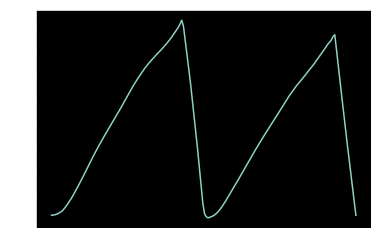

In [3]:
plt.plot(xnew,znew)

In [12]:
#--------------------------------
# Set up the constants
#--------------------------------
s= 0.2      # Surface water elevation
beta = 0.01

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

x = pyclaw.Dimension(0.0,xmax,len(xnew),name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

zc = znew.copy()
z_hydro = znew.copy()

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0


# Set up the inital state of the flow

shw_slvr = shallow_solver(domain, slope=0.00173, mannings=0.022)
u, surf,h = shw_slvr.run(zc,s)


if np.isnan(u).any():
    # Get the flow
    print( u)
    raise ValueError('Failed to calculate the flow')



Grid dx = 0.015
Grid nx = 174


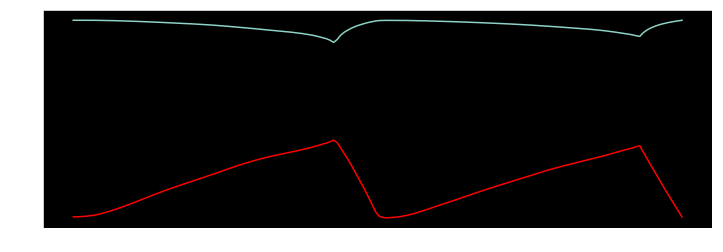

In [13]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,surf)
plt.plot(xc,zc,'r')

0.54795731298667

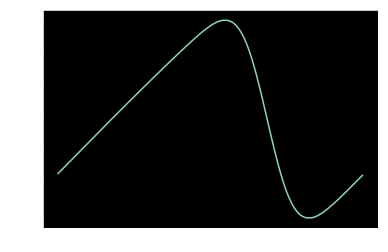

In [6]:
plt.plot(xc, u)

u.mean()

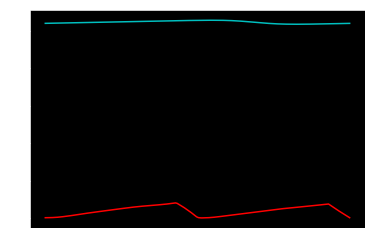

In [7]:
tau20 = np.zeros(nx)
for i in range(0,nx): #i=2
    tau20[i] = sedtrans.get_bed_shear(h[i],u[i],D50)
    
plt.plot(xc,tau20,'c-')

plt.plot(xc,zc,'r')



In [7]:
fig = plt.figure(figsize=(16, 3))
# Set up the inital state of the flow
shw_slvr = shallow_solver(domain)
u32, surf32,h32 = shw_slvr.run(zc,0.32)

tau32 = np.zeros(nx)
for i in range(0,nx): #i=2
    tau32[i] = sedtrans.get_bed_shear(h32[i],u32[i],D50)

<Figure size 1152x216 with 0 Axes>

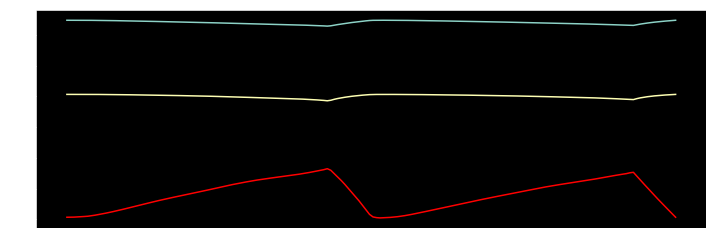

In [8]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,surf32)
plt.plot(xc,surf)
plt.plot(xc,zc,'r')

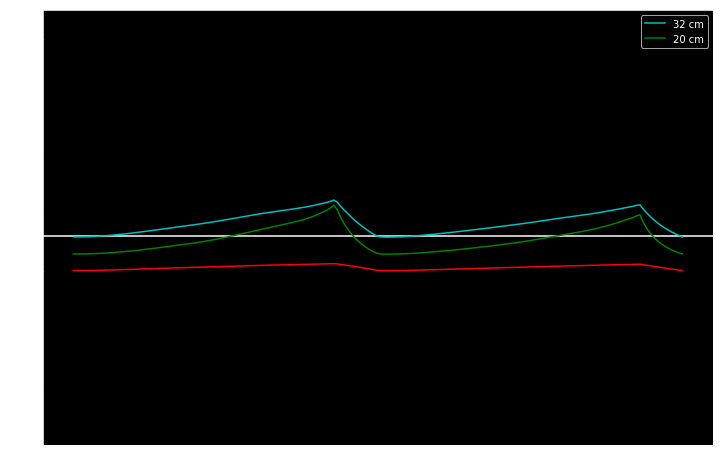

In [11]:
tau_cr = sedtrans.get_critical_shear(D50, rho_particule)
fig = plt.figure(figsize=(12, 8))
plt.axhline(tau_cr)
plt.plot(xc,tau32,'c-',label='32 cm')
plt.plot(xc,tau20,'g-', label='20 cm')
plt.plot(xc,zc*1.5,'r')
plt.ylim([-3., 4.5])
plt.ylabel('Shear Stress (Pa)')
plt.legend()